# Residuals MODEL

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

In [3]:
# read in pickle
df_iq = pd.read_pickle('./df_iq.pkl')
df_sj = pd.read_pickle('./df_sj.pkl')

# create month variable
df_sj['month'] = df_sj.index.month
df_iq['month'] = df_iq.index.month

# train test split
#sj
sj_train = df_sj.loc[:'2007-04-20']
sj_Xtrain = sj_train.drop('total_cases', axis = 1)
sj_ytrain = sj_train[['total_cases']]

sj_test = df_sj.loc['2007-04-20':]
sj_Xtest = sj_test.drop('total_cases', axis = 1)
sj_ytest = sj_test[['total_cases']]

#iq
iq_train = df_iq.loc[:'2009-06-20']
iq_Xtrain = iq_train.drop('total_cases', axis = 1)
iq_ytrain = iq_train[['total_cases']]

iq_test = df_iq.loc['2009-06-20':]
iq_Xtest = iq_test.drop('total_cases', axis = 1)
iq_ytest = iq_test[['total_cases']]

## Get Residuals
From San Juan and Iquitos. Only use training data

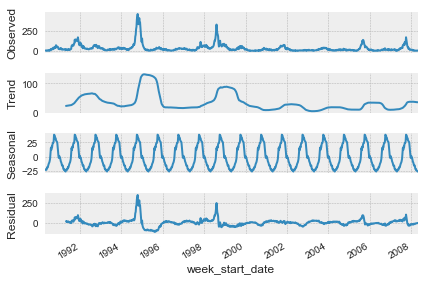

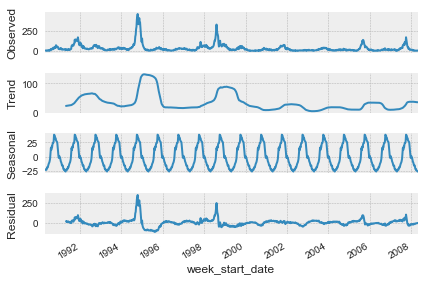

In [312]:
from statsmodels.tsa.seasonal import seasonal_decompose

# freq = 52 because there are 52 weeks in a year

# sj train
decomposition = seasonal_decompose(df_sj['total_cases'], two_sided=False, freq=52)
df_sj['resid'] = decomposition.resid.values
decomposition.plot()
# # iq train
# decomposition = seasonal_decompose(iq_ytrain, two_sided=False, freq=52)
# iq_train['resid'] = decomposition.resid.values



## Use weather features to predict residuals (if more or less than seasonal)

In [5]:
# drop null residuals
sj_train.dropna(inplace=True)
iq_train.dropna(inplace=True)

/Users/alexfreeman/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/alexfreeman/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
sj_train.columns

Index([u'ndvi_ne', u'ndvi_nw', u'ndvi_se', u'ndvi_sw', u'precipitation_amt_mm',
       u'reanalysis_air_temp_k', u'reanalysis_avg_temp_k',
       u'reanalysis_dew_point_temp_k', u'reanalysis_max_air_temp_k',
       u'reanalysis_min_air_temp_k', u'reanalysis_precip_amt_kg_per_m2',
       u'reanalysis_relative_humidity_percent',
       u'reanalysis_sat_precip_amt_mm',
       u'reanalysis_specific_humidity_g_per_kg', u'reanalysis_tdtr_k',
       u'station_avg_temp_c', u'station_diur_temp_rng_c',
       u'station_max_temp_c', u'station_min_temp_c', u'station_precip_mm',
       u'total_cases', u'month', u'resid'],
      dtype='object')

In [203]:
X = sj_train[['precipitation_amt_mm', 'station_precip_mm']]
# X = sj_train.drop(['total_cases', 'resid'], axis = 1)
y = sj_train['resid']

47
47


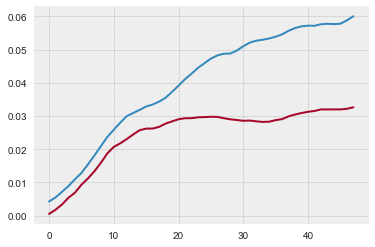

In [204]:
mean_scores = []
for i in range(2, 50):
    lr = LinearRegression()
    X_roll = X.rolling(window = i).mean().dropna()
    y_roll = y[i-1:]
    lr.fit(X_roll, y_roll)
    mean_scores.append(lr.score(X_roll, y_roll))

std_scores = []
for i in range(2, 50):
    lr = LinearRegression()
    X_roll = X.rolling(window = i).std().dropna()
    y_roll = y[i-1:]
    lr.fit(X_roll, y_roll)
    std_scores.append(lr.score(X_roll, y_roll))

plt.plot(mean_scores)
plt.plot(std_scores)

print mean_scores.index(max(mean_scores))
print std_scores.index(max(std_scores))

In [229]:
# function to create rolling vars

def create_mean_roll_df(data, var_list, window):
    roll_df = data[var_list].rolling(window = window).mean()
    return roll_df

def create_std_roll_df(data, var_list, window):
    roll_df = data[var_list].rolling(window = window).std()
    return roll_df


In [238]:
# create various rolling averages for features
sj_ndvi_mean_roll = create_mean_roll_df(df_sj, ['ndvi_ne', u'ndvi_nw', u'ndvi_se', u'ndvi_sw'], 2)
sj_temp_mean_roll = create_mean_roll_df(df_sj, ['station_avg_temp_c', u'station_diur_temp_rng_c',
       u'station_max_temp_c', u'station_min_temp_c'], 15)
sj_precip_mean_roll = create_mean_roll_df(df_sj, ['precipitation_amt_mm', 'station_precip_mm'], 15)
sj_precip_std_roll = create_mean_roll_df(df_sj, ['precipitation_amt_mm', 'station_precip_mm'], 15)


In [249]:
# create rolling mean and std vars, combine into 1 df

X_roll = pd.concat([sj_ndvi_mean_roll, sj_temp_mean_roll, sj_precip_mean_roll, sj_precip_std_roll], axis = 1)[52:]

y_roll = df_sj['resid'][52:]

In [273]:
# split data
split = '2005-04-20'
X_roll_train = X_roll[:split]
y_roll_train = y_roll[:split]
print len(X_roll_train), len(y_roll_train)

X_roll_test = X_roll[split:]
y_roll_test = y_roll[split:]
print len(X_roll_test), len(y_roll_test)

727 727
157 157


In [274]:
lr = LinearRegression()
lr.fit(X_roll_train, y_roll_train.values)
predicts = lr.predict(X_roll_test)
mean_absolute_error(predicts, y_roll_test)
# this is working!

31.746806871628142

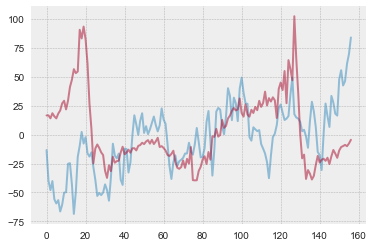

In [275]:
plt.plot(predicts, alpha = .5)
plt.plot(y_roll_test.values, alpha = .5)

# try predicting binary, if resid is 50 above or 50 below later

In [322]:
# get seasonal test values into a list, bring the minimum seasonal to 0
seasonal_test = decomposition.seasonal[split:]
seasonal_test = seasonal_test.apply(lambda x: x - min(seasonal))
# add predicted residuals and to seasonal trend values
predicts = predicts
seas_and_resid = seasonal_test + predicts
# seas_and_resid = seas_and_resid.apply(lambda x: int(x)).apply(lambda x: 0 if x < 1 else x)

In [327]:
df = pd.DataFrame(zip(predicts, seasonal_test))
df['pred_total'] = df[0] + df[1]
pred_total = df['pred_total']

In [328]:
mean_absolute_error(pred_total, y_roll_test)

40.027130211396972

In [310]:
print len(predicts)
print len(seasonal_test)
print len(seas_and_resid)

157
157
314


In [304]:
# no need to predict on residuals...

# add predicted residuals and to seasonal trend values
seasonal = pd.Series(seasonal)[:785]
predicts = pd.Series(predicts)
seas_and_resid = seasonal+predicts
seas_and_resid = seas_and_resid.apply(lambda x: int(x)).apply(lambda x: 0 if x < 1 else x)

In [311]:
predicts = predicts.apply(lambda x: int(x)).apply(lambda x: 0 if x < 1 else x)
# print len(seasonal)
print len(predicts)
# print len(seas_and_resid)
print len(sj_ytrain[92:])

791
791


18.7067003793


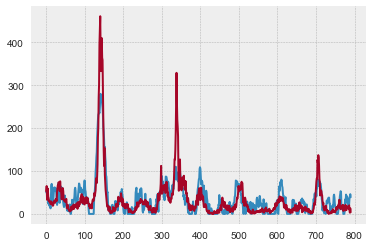

In [312]:
plt.plot(predicts)
plt.plot(sj_ytrain.values[92:])
print mean_absolute_error(predicts, sj_ytrain[92:])

## Test this model
Need to be careful because need old data to tarin rolling means on for future cases...

In [461]:
df_sj.columns

Index([u'ndvi_ne', u'ndvi_nw', u'ndvi_se', u'ndvi_sw', u'precipitation_amt_mm',
       u'reanalysis_air_temp_k', u'reanalysis_avg_temp_k',
       u'reanalysis_dew_point_temp_k', u'reanalysis_max_air_temp_k',
       u'reanalysis_min_air_temp_k', u'reanalysis_precip_amt_kg_per_m2',
       u'reanalysis_relative_humidity_percent',
       u'reanalysis_sat_precip_amt_mm',
       u'reanalysis_specific_humidity_g_per_kg', u'reanalysis_tdtr_k',
       u'station_avg_temp_c', u'station_diur_temp_rng_c',
       u'station_max_temp_c', u'station_min_temp_c', u'station_precip_mm',
       u'total_cases', u'month'],
      dtype='object')

In [570]:
X = df_sj[[u'ndvi_ne', u'ndvi_nw', u'ndvi_se', u'ndvi_sw', u'precipitation_amt_mm',
       u'reanalysis_air_temp_k', u'reanalysis_avg_temp_k',
       u'reanalysis_dew_point_temp_k', u'reanalysis_max_air_temp_k',
       u'reanalysis_min_air_temp_k', u'reanalysis_precip_amt_kg_per_m2',
       u'reanalysis_relative_humidity_percent',
       u'reanalysis_sat_precip_amt_mm',
       u'reanalysis_specific_humidity_g_per_kg', u'reanalysis_tdtr_k',
       u'station_avg_temp_c', u'station_diur_temp_rng_c',
       u'station_max_temp_c', u'station_min_temp_c', u'station_precip_mm']]
y = df_sj['total_cases']

18.9411764706
RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=3,
           max_features=5, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)



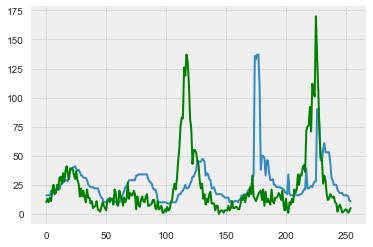

In [636]:
roll_back = 32

# create rolling mean, std month dummy vars, combine into 1 df
X_mean_roll = X.rolling(window = roll_back).mean()[roll_back-1:]
X_std_roll = X.rolling(window = roll_back).std()[roll_back-1:]
X_month_dums = pd.get_dummies(df_sj['month'], prefix='month')[roll_back-1:]
X_roll = pd.concat([X_mean_roll, X_std_roll], axis = 1)

y_roll = y[roll_back-1:]

# split data
split = 650
Xtrain = X_roll[:split]
Xtest = X_roll[split:]
ytrain = y_roll[:split]
ytest = y_roll[split:]

# # model, predict
# lr = LinearRegression()
# lr.fit(Xtrain, ytrain)
# predicts = pd.Series(lr.predict(Xtest))
# predicts = predicts.apply(lambda x: int(x)).apply(lambda x: 10 if x < 1 else x)
# print mean_absolute_error(predicts, ytest)

# rfr grid search model, predict
grid_params = {'n_estimators'   :[25],
               'criterion'      :['mae'],
               'max_features'   :[5, None],
               'max_depth'      :[3, 5, None]}

rfr = RandomForestRegressor()

grid_rfr = GridSearchCV(rfr, grid_params)

grid_rfr.fit(Xtrain, ytrain)
predicts = pd.Series(grid_rfr.predict(Xtest))
predicts = predicts.apply(lambda x: int(x)).apply(lambda x: 10 if x < 1 else x)

#print scores and predictions
print mean_absolute_error(predicts, ytest.values)
print grid_rfr.best_estimator_
print 
plt.plot(predicts)
plt.plot(ytest.values, c = 'g')

In [631]:
# pd.DataFrame(zip(X_roll.columns, rfr.feature_importances_)).sort_values(1, ascending = False).head(10)

In [1]:
# for loop through how many weeks back to average
mae = []
for i in range(30, 200):
    roll_back = i

    # create rolling mean, std month dummy vars, combine into 1 df
    X_mean_roll = X.rolling(window = roll_back).mean()[roll_back-1:]
    X_std_roll = X.rolling(window = roll_back).std()[roll_back-1:]
    X_month_dums = pd.get_dummies(df_sj['month'], prefix='month')[roll_back-1:]
    X_roll = pd.concat([X_mean_roll, X_std_roll, X_month_dums], axis = 1)

    y_roll = y[roll_back-1:]

    # split data
    split = 600
    Xtrain = X_roll[:split]
    Xtest = X_roll[split:]
    ytrain = y_roll[:split]
    ytest = y_roll[split:]

    # model, predict
    lr = LinearRegression()
    lr.fit(Xtrain, ytrain)
    predicts = pd.Series(lr.predict(Xtest))
    predicts = predicts.apply(lambda x: int(x)).apply(lambda x: 10 if x < 1 else x)

    mae.append(mean_absolute_error(predicts, ytest))


NameError: name 'X' is not defined

126


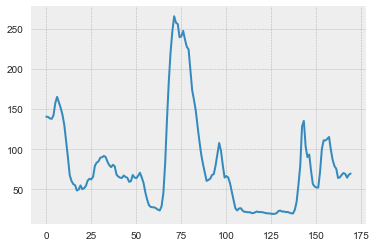

In [573]:
print mae.index(min(mae))
plt.plot(mae)

In [576]:
# for loop through how many weeks back to average
mae = []
for i in range(3, 65):
    roll_back = i

    # create rolling mean, std month dummy vars, combine into 1 df
    X_mean_roll = X.rolling(window = roll_back).mean()[roll_back-1:]
    X_std_roll = X.rolling(window = roll_back).std()[roll_back-1:]
    X_month_dums = pd.get_dummies(df_sj['month'], prefix='month')[roll_back-1:]
    X_roll = pd.concat([X_mean_roll, X_std_roll, X_month_dums], axis = 1)

    y_roll = y[roll_back-1:]

    # split data
    split = 600
    Xtrain = X_roll[:split]
    Xtest = X_roll[split:]
    ytrain = y_roll[:split]
    ytest = y_roll[split:]

    # rfr model, predict
    rfr = RandomForestRegressor()
    rfr.fit(Xtrain, ytrain)
    predicts = pd.Series(rfr.predict(Xtest))
    predicts = predicts.apply(lambda x: int(x)).apply(lambda x: 10 if x < 1 else x)

    mae.append(mean_absolute_error(predicts, ytest))


34


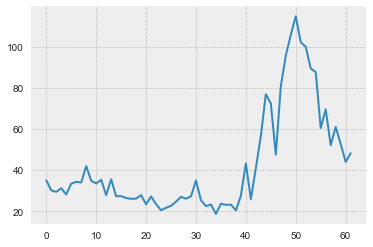

In [577]:
print mae.index(min(mae))
plt.plot(mae)

## Pipeline into predictions on test data

In [683]:
# Set up test data to fit into model

# read in test data
test = pd.read_csv('./datasets/dengue_features_test.csv', parse_dates=[3])
submission_format = pd.read_csv('./datasets/submission_format.csv')

#split into cities df
test_sj = test[test['city'] == 'sj']
test_iq = test[test['city'] == 'iq']

# FrontFill to Impute into Missing values
test_sj = test_sj.fillna(method = 'ffill')
test_iq = test_iq.fillna(method = 'ffill')

# set index to the dates
test_sj.set_index('week_start_date', drop = True, inplace = True)
test_iq.set_index('week_start_date', drop = True, inplace = True)

# drop non-numerical values
test_sj.drop(['city', 'year', 'weekofyear'], axis = 1, inplace = True)
test_iq.drop(['city', 'year', 'weekofyear'], axis = 1, inplace = True)

# create month variable
test_sj['month'] = test_sj.index.month
test_iq['month'] = test_iq.index.month

In [684]:
feats = ['precipitation_amt_mm', 'station_max_temp_c', 'station_min_temp_c']

### SJ PREDICTIONS

In [693]:
len(df_sj)

936

In [704]:
# combine training and testing data
sj_all = pd.concat([df_sj.drop('total_cases', axis = 1), test_sj], axis = 0)

X = sj_all[feats]
y = df_sj['total_cases']

#set how many weeks to roll back
roll_back = 42

# create rolling mean, std month dummy vars, combine into 1 df
X_mean_roll = X.rolling(window = roll_back).mean()[roll_back-1:]
X_std_roll = X.rolling(window = roll_back).std()[roll_back-1:]
X_month_dums = pd.get_dummies(sj_all['month'], prefix='month')[roll_back-1:]
X_roll = pd.concat([X_mean_roll, X_std_roll], axis = 1)

y_roll = y

# split data
split = 936 - (roll_back - 1)
Xtrain = X_roll[:split]
Xtest = X_roll[split:]
ytrain = y_roll[:split]
ytest = y_roll[split:]

# # model, predict
# lr = LinearRegression()
# lr.fit(Xtrain, ytrain)
# predicts = pd.Series(lr.predict(Xtest))
# predicts = predicts.apply(lambda x: int(x)).apply(lambda x: 10 if x < 1 else x)
# print mean_absolute_error(predicts, ytest)

# rfr grid search model, predict
grid_params = {'n_estimators'   :[25],
               'criterion'      :['mae'],
               'max_features'   :[5, None],
               'max_depth'      :[3, 5, None]}

rfr = RandomForestRegressor()

grid_rfr = GridSearchCV(rfr, grid_params)

grid_rfr.fit(Xtrain, ytrain)
sj_predicts = pd.Series(grid_rfr.predict(Xtest))
sj_predicts = sj_predicts.apply(lambda x: int(x)).apply(lambda x: 10 if x < 1 else x)

print len(sj_predicts), len(test_sj)

260 260


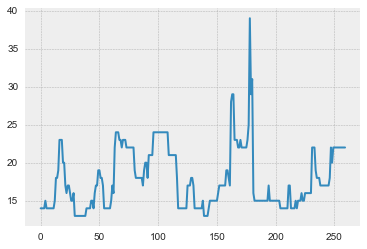

In [705]:
plt.plot(sj_predicts)

### IQ PREDICTIONS

In [708]:
# combine training and testing data
iq_all = pd.concat([df_iq.drop('total_cases', axis = 1), test_iq], axis = 0)

X = iq_all[feats]
y = df_iq['total_cases']

#set how many weeks to roll back
roll_back = 42

# create rolling mean, std month dummy vars, combine into 1 df
X_mean_roll = X.rolling(window = roll_back).mean()[roll_back-1:]
X_std_roll = X.rolling(window = roll_back).std()[roll_back-1:]
X_month_dums = pd.get_dummies(df_iq['month'], prefix='month')[roll_back-1:]
X_roll = pd.concat([X_mean_roll, X_std_roll], axis = 1)

y_roll = y

# split data
split = 520 - (roll_back - 1)
Xtrain = X_roll[:split]
Xtest = X_roll[split:]
ytrain = y_roll[:split]
ytest = y_roll[split:]

# # model, predict
# lr = LinearRegression()
# lr.fit(Xtrain, ytrain)
# predicts = pd.Series(lr.predict(Xtest))
# predicts = predicts.apply(lambda x: int(x)).apply(lambda x: 10 if x < 1 else x)
# print mean_absolute_error(predicts, ytest)

# rfr grid search model, predict
grid_params = {'n_estimators'   :[25],
               'criterion'      :['mae'],
               'max_features'   :[5, None],
               'max_depth'      :[3, 5, None]}

rfr = RandomForestRegressor()

grid_rfr = GridSearchCV(rfr, grid_params)

grid_rfr.fit(Xtrain, ytrain)
iq_predicts = pd.Series(grid_rfr.predict(Xtest))
iq_predicts = iq_predicts.apply(lambda x: int(x)).apply(lambda x: 1 if x < 1 else x)

print len(iq_predicts), len(test_iq), len(Xtest)

156 156 156


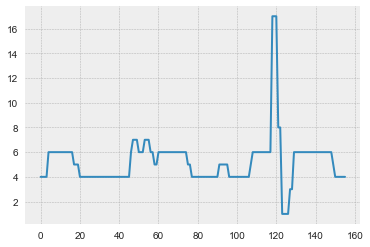

In [709]:
plt.plot(iq_predicts)

In [710]:
## Combine predictions

predictions = pd.concat([sj_predicts, iq_predicts], axis = 0)

In [711]:
submission_format['total_cases'] = predictions.reset_index(drop=True)

In [670]:
# Save to CSV, use current date
submission_format.to_csv('submissions/dengue_submission_9_9_17v2.csv', index=False)

In [ ]:
# MAE of 26.5144 only using monthly trends...